In [2]:
import numpy as np 
from backend.utils.modified_mdtw import generate_synthetic_data, prepare_person
from backend.utils.plotting_tools import create_time_series_plot
import json



Let's assume we ingested some data from NoSQL database in the format below. We did some survey on people's daily diatery habits. In each meal, we asked how much calorie, fat or another parameter at what time is consumed. However for simplification, just for now nutrients are saved as calories per meal. I got the inspiration from the paper in the below: 

N. Khanna, H. A. Eicher-Miller, H. K. Verma, C. J. Boushey, S. B. Gelfand and E. J. Delp, "Modified dynamic time warping (MDTW) for estimating temporal dietary patterns," 2017 IEEE Global Conference on Signal and Information Processing (GlobalSIP), Montreal, QC, Canada, 2017, pp. 948-952, doi: 10.1109/GlobalSIP.2017.8309100.
keywords: {Sociology;Diseases;Time measurement;Estimation;Mathematical model;Histograms;Temporal dietary pattern (TDP);Dynamic time warping (DTW);Modified dynamic time warping (MDTW);k-means clustering;National Health and Nutrition Examination Survey (NHANES)},

| Feature | Traditional DTW | **Modified DTW (MDTW)** |
|--------|------------------|---------------------------|
| ✅ Uses order of events | ✔️ Yes | ✔️ Yes |
| ❌ Uses actual time of day | ❌ No | ✔️ **Yes** |
| ✅ Handles unequal sequence lengths | ✔️ Yes | ✔️ Yes |
| ❌ Allows meal skipping | ❌ No (forces warping) | ✔️ **Yes, with penalty** |
| ❌ Distinguishes eating at 13:00 vs 20:00 | ❌ No | ✔️ **Explicit penalty** |
| ❌ Understands “silence zones” | ❌ No | ✔️ **Yes (via ∅ matches)** |
| ❌ Normalizes food scale | ❌ No | ✔️ **With weight matrix \(W\)** |
| ❌ Models nutritional importance | ❌ No | ✔️ **With \( \beta \), \( \alpha \)** |

In [3]:
np.random.seed(42)  # For reproducibility

raw_data = generate_synthetic_data(num_people=5, min_meals=1, max_meals=5, min_calories=200, max_calories=800)
pretty_data=json.dumps(raw_data, indent=4)
print(pretty_data)

[
    {
        "person_id": "person_1",
        "records": [
            {
                "time": 0.0,
                "nutrients": [
                    659.0
                ]
            },
            {
                "time": 8.0,
                "nutrients": [
                    513.0
                ]
            },
            {
                "time": 16.0,
                "nutrients": [
                    221.0
                ]
            },
            {
                "time": 19.0,
                "nutrients": [
                    452.0
                ]
            }
        ]
    },
    {
        "person_id": "person_2",
        "records": [
            {
                "time": 7.0,
                "nutrients": [
                    764.0
                ]
            },
            {
                "time": 10.0,
                "nutrients": [
                    539.0
                ]
            },
            {
                "time": 12.0,
                "

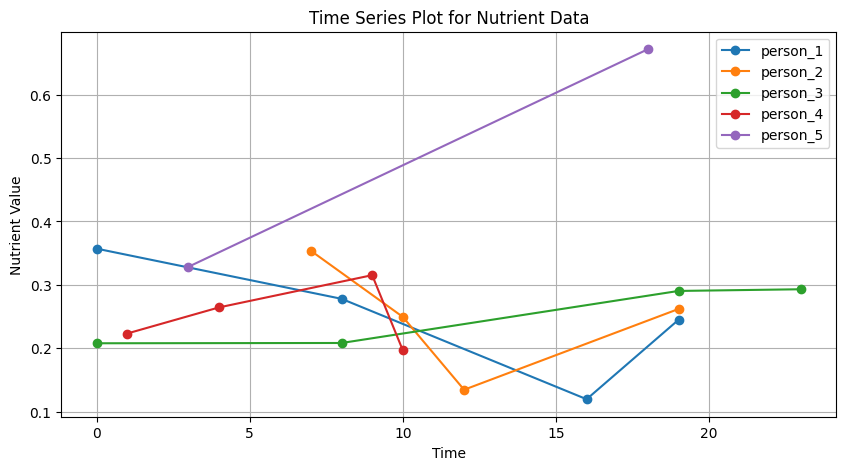

In [4]:
prepared_data = {person['person_id']: prepare_person(person) for person in raw_data}
# Create a time series plot for each person
create_time_series_plot(prepared_data)

In [5]:
from backend.utils.modified_mdtw import local_distance, mdtw_distance,calculate_distance_matrix
from backend.utils.plotting_tools import plot_heatmap
from itertools import zip_longest



In [6]:
mdtw_distance_matrix = calculate_distance_matrix(prepared_data, traditional=False)
print("MDTW Distance Matrix:")
print(mdtw_distance_matrix)

MDTW Distance Matrix:
[[0.         0.02676885 0.06408565 0.08517034 0.27900783]
 [0.02676885 0.         0.0744579  0.09106929 0.25640576]
 [0.06408565 0.0744579  0.         0.08827916 0.29213701]
 [0.08517034 0.09106929 0.08827916 0.         0.28472921]
 [0.27900783 0.25640576 0.29213701 0.28472921 0.        ]]


In [7]:
traditional_distance_matrix = calculate_distance_matrix(prepared_data, traditional=True)
print("Traditional Distance Matrix:")
print(traditional_distance_matrix)
# Plot the heatmap for the global cost matrix

Traditional Distance Matrix:
[[0.         0.00133891 0.05855775 0.05865759 0.22999083]
 [0.00133891 0.         0.04814744 0.05409543 0.24871185]
 [0.05855775 0.04814744 0.         0.01328148 0.23130946]
 [0.05865759 0.05409543 0.01328148 0.         0.2195564 ]
 [0.22999083 0.24871185 0.23130946 0.2195564  0.        ]]


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot the heatmap for the global cost matrix

labels = list(prepared_data.keys())
# Use the same vmin/vmax for shared colormap
vmin = min(traditional_distance_matrix.min(), mdtw_distance_matrix.min())
vmax = max(traditional_distance_matrix.max(), mdtw_distance_matrix.max())

# Create heatmaps
im1 = ax1.imshow(traditional_distance_matrix, vmin=vmin, vmax=vmax, cmap='viridis')
im2 = ax2.imshow(mdtw_distance_matrix, vmin=vmin, vmax=vmax, cmap='viridis')

# Set titles
ax1.set_title("Traditional DTW")
ax2.set_title("Modified DTW (MDTW)")

# Set ticks
for ax in [ax1, ax2]:
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

# Add shared colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.7, orientation='vertical')
cbar.set_label("Distance")

plt.tight_layout()